# EECS 498-007/598-005 Assignment 4-1: One-Stage Object Detector

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Firstname Lastname, #sui1234bian

# FCOS: A Simple One-Stage and Anchor-Free Object Detector

In this exercise you will implement a **one-stage** object detector based on [FCOS: Fully-Convolutional One-Stage Object Detection](https://arxiv.org/abs/1904.01355) and train it to detect a set of object classes.
Our detector design is highly similar to FCOS itself, except we train a smaller model with slightly different hyperparameters to manage with limited resources on Colab.

We will also evaluate the detection accuracy using the classic metric mean Average Precision ([mAP](https://github.com/Cartucho/mAP)).

# Getting Started

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as previous assignments. You"ll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
# from google.colab import drive

# drive.mount("/content/drive")

Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the following cell should print the filenames from the assignment:

```
["common.py", "one_stage_detector.ipynb", "two_stage_detector_faster_rcnn.ipynb", "eecs598", "one_stage_detector.py", "two_stage_detector.py", "a4_helper.py"]
```

In [3]:
import os
import sys

# # TODO: Fill in the Google Drive path where you uploaded the assignment
# # Example: If you create a 2022WI folder and put all the files under A4 folder, then "2022WI/A4"
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
# GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
# print(os.listdir(GOOGLE_DRIVE_PATH))


# # Add to sys so we can import .py files.
# sys.path.append(GOOGLE_DRIVE_PATH)

Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from common.py!
Hello from one_stage_detector.py!
Hello from a4_helper.py!
```

as well as the last edit time for the file `one_stage_detector.py`.

In [4]:
import os
import time

os.environ["TZ"] = "US/Eastern"

from common import hello_common
from one_stage_detector import hello_one_stage_detector
from a4_helper import hello_helper


hello_common()
hello_one_stage_detector()
hello_helper()

one_stage_detector_path = os.path.join('.', "one_stage_detector.py")
one_stage_detector_edit_time = time.ctime(
    os.path.getmtime(one_stage_detector_path)
)
print("one_stage_detector.py last edited on %s" % one_stage_detector_edit_time)

Hello from common.py!
Hello from one_stage_detector.py!
Hello from a4_helper.py!
one_stage_detector.py last edited on Thu Oct 31 20:47:17 2024


Load several useful packages that are used in this notebook:

In [5]:
import os
import time

import matplotlib.pyplot as plt
import torch
import torchvision

%matplotlib inline

from a4_helper import *
from eecs598 import reset_seed
from eecs598.grad import rel_error

# for plotting
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["font.size"] = 16
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

# # To download the dataset
# !pip install wget

# # for mAP evaluation
# !rm -rf mAP
# !git clone https://github.com/Cartucho/mAP.git
# !rm -rf mAP/input/*

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [6]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")

Good to go!


## Load PASCAL VOC 2007 data
During the majority of our homework assignments so far, we have used the CIFAR-10 dataset for image classification tasks.

In order to train and evaluate object detection models, we need a dataset where each image is annotated with a *set* of *bounding boxes*, where each box gives the category label and spatial extent of some object in the image.

We will use the [PASCAL VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/) dataset, which provides annotations of this form. PASCAL VOC ran a series of yearly computer vision competitions from 2005 to 2012, predating the ImageNet challenge which we have discussed in class.
The data from the 2007 challenge used to be one of the most popular datasets for evaluating object detection.
It is much smaller than more recent object detection datasets such as [COCO](http://cocodataset.org/#home), and thus easier to manage in an homework assignment.
VOC comprises annotated bounding boxes for 20 object classes:
`["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]`.

We create a [`PyTorch Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class
named `VOC2007DetectionTiny` in `a4_helper.py` will download the PASCAL VOC 2007 dataset.
This class returns annotations for each image as a nested set of dictionary objects.

Run the following two cells to set a few config parameters and then download the train/val sets for the PASCAL VOC 2007 dataset.

In [7]:
import multiprocessing

# Set a few constants related to data loading.
NUM_CLASSES = 20
BATCH_SIZE = 16
IMAGE_SHAPE = (224, 224)
NUM_WORKERS = multiprocessing.cpu_count()

### NOTE: You should not hard-code any of these above values in your implementation.

For example, do not use the value "224" while performing any view operations with image features or such. We may test your implementation with different image sizes, batch sizes and dataset subsets.
They would of course yield different final accuracies and that's expected, but your code should not error on Autograder.
As with prior assignments, write dtype and device agnostic code.
Use `DEVICE` constant like we did in previous cell, check [@520](https://piazza.com/class/kxtai72amx34p0?cid=520) on Piazza for tips.


### Download the dataset first.

We provide images and pre-processed annotation files here. They need to be in `GOOGLE_DRIVE_PATH` the following directory structure:

```bash
GOOGLE_DRIVE_PATH
    - VOCdevkit/   # Extracted from `VOCtrainval_06-Nov-2007.tar
        - VOC2007/
            - JPEGImages/
            # Other directories like `SegmentationClass`, `SegmentationObject` etc. are not needed
    - voc07_train.json
    - voc07_val.json
```

The following cell can download them automatically for you.
However, Colab may hang indefinitely sometimes. We do not have a clear reason for why that happens.
In that case, you may download these manually on your machine, and upload them to Google Drive.
These commands will work for for Linux/Mac:

```
wget https://web.eecs.umich.edu/~justincj/data/VOCtrainval_06-Nov-2007.tar
tar xvf https://web.eecs.umich.edu/~justincj/data/VOCtrainval_06-Nov-2007.tar
wget https://web.eecs.umich.edu/~justincj/data/voc07_train.json
wget https://web.eecs.umich.edu/~justincj/data/voc07_val.json
```

In [8]:
from a4_helper import VOC2007DetectionTiny

# NOTE: Set `download=True` for the first time when you set up Google Drive folder.
# Turn it back to `False` later for faster execution in the future.
# If this hangs, download and place data in your drive manually as shown above.
train_dataset = VOC2007DetectionTiny(
    './data', "train", image_size=IMAGE_SHAPE[0],
    download=False  # True (for the first time)
)
val_dataset = VOC2007DetectionTiny('./data', "val", image_size=IMAGE_SHAPE[0])

print(f"Dataset sizes: train ({len(train_dataset)}), val ({len(val_dataset)})")

Dataset sizes: train (2501), val (2510)


To train our detector, we need to convert individual images (JPEG) and annotations (XML files) into batches of tensors. We perform this by wrapping our datasets with a PyTorch [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) object.
We have implemented it in `a4_helper.py` - you are not required to understand its implementation, however you should understand the format of its output (which we will explore next).

In [9]:
# `pin_memory` speeds up CPU-GPU batch transfer, `num_workers=NUM_WORKERS` loads data
# on the main CPU process, suitable for Colab.
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS
)

# Use batch_size = 1 during inference - during inference we do not center crop
# the image to detect all objects, hence they may be of different size. It is
# easier and less redundant to use batch_size=1 rather than zero-padding images.
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, pin_memory=True, num_workers=NUM_WORKERS
)

The `DataLoader` objects return batches of data.

The first output from the `DataLoader` is a Tensor `image` of shape `(B, 3, IMAGE_SHAPE[0], IMAGE_SHAPE[1])`. This is a batch of `B` images, similar to what we have seen in classification datasets.

The second output from the `DataLoader` is a Tensor `gt_boxes` of shape `(B, N, 5)` giving information about all objects in all images of the batch. `gt_boxes[i, j] = (x1, y1, x2, y2, C)` gives information about the `j`th object in `image[i]`. The position of the top-left corner of the box is `(x1, y1)` and the position of the bottom-right corner of the box is `(x2, x2)`. These coordinates are real-valued in `[0, 224]`. `C` is an integer giving the category label for this bounding box. This `(x1, y1, x2, y2)` format for bounding boxes is commonly referred as XYXY format.

Each image can have different numbers of objects. If `image[i]` has $N_i$ objects, then $N = \max_i(N_i)$ is the maximum number of objects per image among all objects in the batch; this value can vary from batch to batch. For the images that have fewer than $N$ annotated objects, only the first $N_i$ rows of `gt_boxes[i]` contain annotations; the remaining rows are padded with -1.

image_paths, images, gt_boxes = next(train_loader_iter)记得改成这样

In [10]:
train_loader_iter = iter(train_loader)
image_paths, images, gt_boxes = next(train_loader_iter)

print(f"image paths           : {image_paths}")
print(f"image batch has shape : {images.shape}")
print(f"gt_boxes has shape    : {gt_boxes.shape}")

print(f"Five boxes per image  :")
print(gt_boxes[:, :5, :])

image paths           : ['./data\\VOCdevkit/VOC2007/JPEGImages/000012.jpg', './data\\VOCdevkit/VOC2007/JPEGImages/000017.jpg', './data\\VOCdevkit/VOC2007/JPEGImages/000023.jpg', './data\\VOCdevkit/VOC2007/JPEGImages/000026.jpg', './data\\VOCdevkit/VOC2007/JPEGImages/000032.jpg', './data\\VOCdevkit/VOC2007/JPEGImages/000033.jpg', './data\\VOCdevkit/VOC2007/JPEGImages/000034.jpg', './data\\VOCdevkit/VOC2007/JPEGImages/000035.jpg', './data\\VOCdevkit/VOC2007/JPEGImages/000036.jpg', './data\\VOCdevkit/VOC2007/JPEGImages/000042.jpg', './data\\VOCdevkit/VOC2007/JPEGImages/000044.jpg', './data\\VOCdevkit/VOC2007/JPEGImages/000047.jpg', './data\\VOCdevkit/VOC2007/JPEGImages/000048.jpg', './data\\VOCdevkit/VOC2007/JPEGImages/000061.jpg', './data\\VOCdevkit/VOC2007/JPEGImages/000064.jpg', './data\\VOCdevkit/VOC2007/JPEGImages/000066.jpg']
image batch has shape : torch.Size([16, 3, 224, 224])
gt_boxes has shape    : torch.Size([16, 40, 5])
Five boxes per image  :
tensor([[[ 48.9369,  65.2493, 180

## Visualize PASCAL VOC 2007

Before starting to build your model, it is highly recommended that you visualize your training data and observe some examples. This can help uncover any bugs in dataloading and sometimes even give you strong intuitions to include a modeling component!

We also use a function to visualize our detections, implemented in `eecs598/utils.py`. You are not required to understand it but we encourage you to read it! Here we sample some images from the PASCAL VOC 2007 training set, and visualize the ground-truth object boxes and category labels:

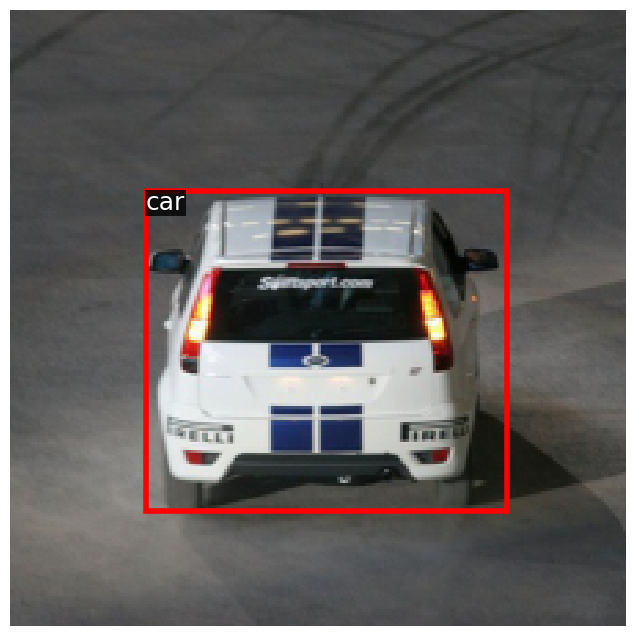

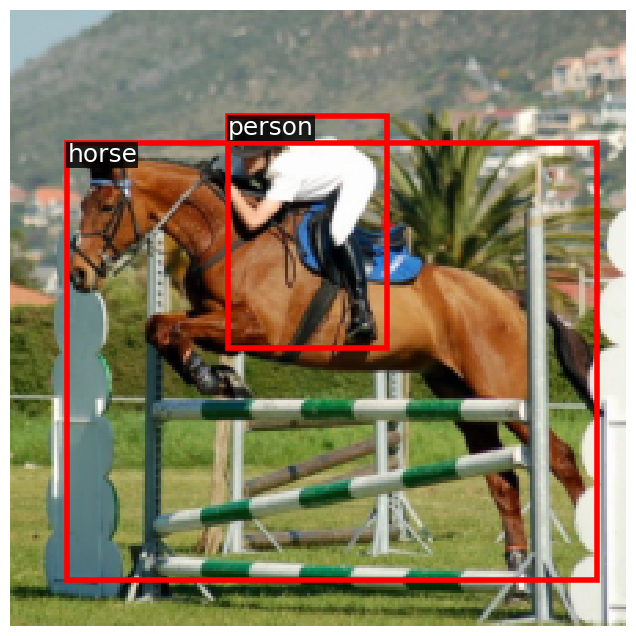

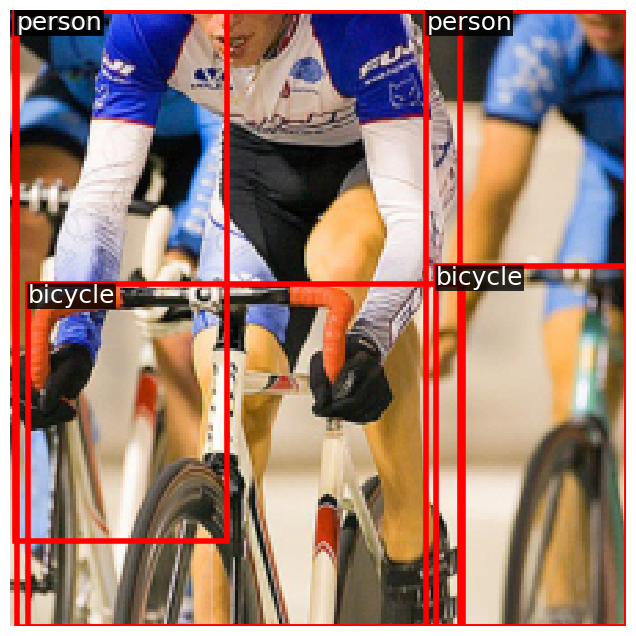

In [11]:
from torchvision import transforms
from eecs598.utils import detection_visualizer

# Define an "inverse" transform for the image that un-normalizes by ImageNet color
# and mean. Without this, the images will NOT be visually understandable.
inverse_norm = transforms.Compose(
    [
        transforms.Normalize(mean=[0., 0., 0.], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
    ]
)

for idx, (_, image, gt_boxes) in enumerate(train_dataset):
    # Stop after visualizing three images.
    if idx > 2:
        break

    # Un-normalize image to bring in [0, 1] RGB range.
    image = inverse_norm(image)

    # Remove padded boxes from visualization.
    is_valid = gt_boxes[:, 4] >= 0
    detection_visualizer(image, val_dataset.idx_to_class, gt_boxes[is_valid])

## Implementing FCOS

FCOS is a fully-convolutional one-stage object detection model — unlike two-stage detectors like Faster R-CNN, it does not comprise any custom modules like anchor boxes, RoI pooling/align, and RPN proposals (for second stage). Due to its simplicity, you will implement core components of FCOS in this first half of the assignment, and then re-use many of them to implement Faster R-CNN in the second half.

An overview of the model in shown below. In case it does not load, see [Figure 2 in FCOS paper](https://arxiv.org/abs/1904.01355).
It details three modeling components: backbone, feature pyramid network (FPN), and head (prediction layers).
First, we will implement FCOS as shown in this figure, and then implement components to train it with the PASCAL VOC 2007 dataset we loaded above.

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-23_at_3.34.09_PM_SAg1OBo.png" alt="FCOS Model Figure" width="80%">

> **CAUTION:** The original FCOS model (as per figure above, and lecture slides) places the centerness predictor in parallel with classification predictor. However, we will follow the widely prevalent implementation practice to place the centerness predictor in parallel with box regression predictor.
The main intuition is that centerness and box regression are localization-related quantities and hence would benefit to have shared features.

## Implementing Backbone and Feature Pyramid Network

First, we start building the backbone and FPN of our detector (blue and green parts above). It is the core component that takes in an image and outputs its features of different scales. It can be any type of convolutional network that progressively downsamples the image (e.g. via intermediate max pooling).

Here, we use a small [RegNetX-400MF](https://pytorch.org/vision/stable/models.html#torchvision.models.regnet_x_400mf) as the backbone so we can train in reasonable time on Colab. We have already implemented the minimal logic to initialize this backbone from pre-trained ImageNet weights and extract intermediate features `(c3, c4, c5)` as shown in the figure above.
These features `(c3, c4, c5)` have height and width that is ${1/8}^{th}$, ${1/16}^{th}$, and ${1/32}^{th}$ of the input image respectively.
These values `(8, 16, 32)` are called the "stride" of these features.
In other words, it means that moving one location on the FPN level is equivalent to moving `stride` pixels in the input image.

You need to implement extra modules to attach the FPN to this backbone. For more details, see Figure 3 in [FPN paper](https://arxiv.org/abs/1612.03144).
FPN will convert these `(c3, c4, c5)` multi-scale features to `(p3, p4, p5)`. These notations "p3", "p4", "p5" are called _FPN levels_.
Before you write any code, let's initialize the backbone in the next cell. You should see the shape of `(c3, c4, c5)` features for an input image:

In [12]:
import torch
from common import DetectorBackboneWithFPN

backbone = DetectorBackboneWithFPN(out_channels=64)

c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_X_400MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_X_400MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])


Follow the instructions in `common.py` to implement additional FPN layers for transforming `(c3, c4, c5)` to `(p3, p4, p5)`.
For training a small enough model on Google Colab, we leave out `(p6, p7)` as shown in the Figure.
Output features from these FPN levels are expected to have same height and width as backbone features, but now they should have the same number of channels.

In [13]:
import torch
from common import DetectorBackboneWithFPN

backbone = DetectorBackboneWithFPN(out_channels=64)
print("Extra FPN modules added:")
print(backbone.fpn_params)

# Pass a batch of dummy images (random tensors) in NCHW format and observe the output.
dummy_images = torch.randn(2, 3, 224, 224)

# Collect dummy output.
dummy_fpn_feats = backbone(dummy_images)

print(f"For dummy input images with shape: {dummy_images.shape}")
for level_name, feat in dummy_fpn_feats.items():
    print(f"Shape of {level_name} features: {feat.shape}")

For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])
Extra FPN modules added:
ModuleDict(
  (c3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (c4): Conv2d(160, 64, kernel_size=(1, 1), stride=(1, 1))
  (c5): Conv2d(400, 64, kernel_size=(1, 1), stride=(1, 1))
  (p3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (p4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (p5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
)
For dummy input images with shape: torch.Size([2, 3, 224, 224])
Shape of p3 features: torch.Size([2, 64, 30, 30])
Shape of p4 features: torch.Size([2, 64, 16, 16])
Shape of p5 features: torch.Size([2, 64, 9, 9])


## Implementing FCOS prediction network (head)

By this point, you have implemented the backbone and FPN — you will reuse your implementation in the second half, for Faster R-CNN.
Now we implement the "head" prediction layers (**orange** blocks in the Figure above). This head has shared weights across all FPN levels, and its purpose is to predict an object class, bounding box, and centerness at every location.

Look closely at the right block in the Figure which shows the inner components of head. It comprises 4-convolution layers that produce `(H, W, 256)` features (different H, W for different FPN levels) and then use one convolutional layer each to make final predictions. 

You will now add these modules in `FCOSPredictionNetwork` in `one_stage_detector.py` — follow instructions in its documentation.
Below we show how to initialize and use this module.

In the expected output. the classification logits have `NUM_CLASSES` channels, box regression deltas have 4 output channels, and centerness has 1 output channels.
The height and width of all outputs is flattened to one dimension, resulting in `(B, H * W, C)` format - this format is more convenient for computing loss, as you will see later.


In [14]:
from one_stage_detector import FCOSPredictionNetwork

# Tiny head with `in_channels` as FPN output channels in prior cell,
# and two conv layers in stem.
pred_net = FCOSPredictionNetwork(
    num_classes=NUM_CLASSES, in_channels=64, stem_channels=[64, 64]
)

print("FCOS prediction network parameters:")
print(pred_net)

# Pass the dummy output from FPN (obtained in previous cell) to the head.
dummy_preds = pred_net(dummy_fpn_feats)

pred_cls_logits, pred_boxreg_deltas, pred_ctr_logits = dummy_preds

print("Classification logits:")
for level_name, feat in pred_cls_logits.items():
    print(f"Shape of {level_name} predictions: {feat.shape}")

print("Box regression deltas:")
for level_name, feat in pred_boxreg_deltas.items():
    print(f"Shape of {level_name} predictions: {feat.shape}")

print("Centerness logits:")
for level_name, feat in pred_ctr_logits.items():
    print(f"Shape of {level_name} predictions: {feat.shape}")

FCOS prediction network parameters:
FCOSPredictionNetwork(
  (stem_cls): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (stem_box): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
  )
  (pred_cls): Conv2d(64, 20, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pred_box): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pred_ctr): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
)
Classification logits:
Shape of p3 predictions: torch.Size([2, 900, 20])
Shape of p4 predictions: torch.Size([2, 256, 20])
Shape of p5 predictions: torch.Size([2, 81, 20])
Box regression deltas:
Shape of p3 predictions: torch.Size([2, 900, 4])
Shape of p4 predictions: torch.Size([2, 256, 4]

## How to train your FCOS?

You have now finished implementing FCOS and it is ready to train!
Did you notice that all the custom trainable layers you implemented so far — in FPN and in prediction layers — are convolutional layers?
Due to this design, FCOS gets _fully-convolutional_ in its name!
It performs object detection with _only_ convolution layers, and no special anchors, proposals etc.
The next few steps focus on preparing the training pipeline for FCOS.

Recall that image classification models are trained with `(image, label)` pairs,
where `label` is an integer (more concretely a one-hot vector) that is associated with the _entire_ image.
You cannot train an object detector in this fashion because of two reasons:

1. Each image has a variable number of bounding boxes (and their class labels).
2. Any class label is not associated with an entire image, but rather only a small region enclosed by the bounding box.

Since the object detector classifies every location in feature map along with a bounding box and centerness, we need to supervise every prediction with _one and only one_ GT target. In next few cells, you will work through this assignment procedure between predictions and GT boxes.

## Assigning a GT target to every model prediction

FCOS heads make three predictions at every location: object class, bounding box, and centerness.
We need to assign a GT target for each of them during training. All three predictions correspond to a single location on an FPN level `(p3, p4, p5)`, so instead we can view this problem as assigning GT boxes (and their class labels) to every FPN feature map location.

GT boxes are available (from the dataloader) as 5D vectors `(x1, y1, x2, y2, C)` where `(x1, y1)` is the top-left co-ordinate and `(x2, y2)` is the bottom-right co-ordinate of the bounding box, and `C` is its object class label. These co-ordinates are absolute and real-valued in image dimensions. To begin with the assignment, we will represent every location on an FPN level with `(xc, yc)` absolute and real-valued co-ordinates of a point on the image, that are centers of the receptive fields of those features.

For example, given features from FPN level having shape `(batch_size, channels, H / stride, W / stride)` and the location `feature[:, :, i, j]` will map to the image pixel `(stride * (i + 0.5), stride * (j + 0.5))` - 0.5 indicates the shift from top-left corner to the center of "stride box".

Implement the `get_fpn_location_coords` in `common.py` to get `(xc, yc)` location co-ordinates of all FPN features. Follow its documentation and see its usage example in the following cell:

First five locations per FPN level (absolute image co-ordinates):
p3: [[4.0, 4.0], [4.0, 12.0], [4.0, 20.0], [4.0, 28.0], [4.0, 36.0]]
rel error:  0.0
p4: [[8.0, 8.0], [8.0, 24.0], [8.0, 40.0], [8.0, 56.0], [8.0, 72.0]]
rel error:  0.0
p5: [[16.0, 16.0], [16.0, 48.0], [16.0, 80.0], [16.0, 112.0], [16.0, 144.0]]
rel error:  0.0
********************************************************************************
All locations of the image FPN level = p3
stride = 8


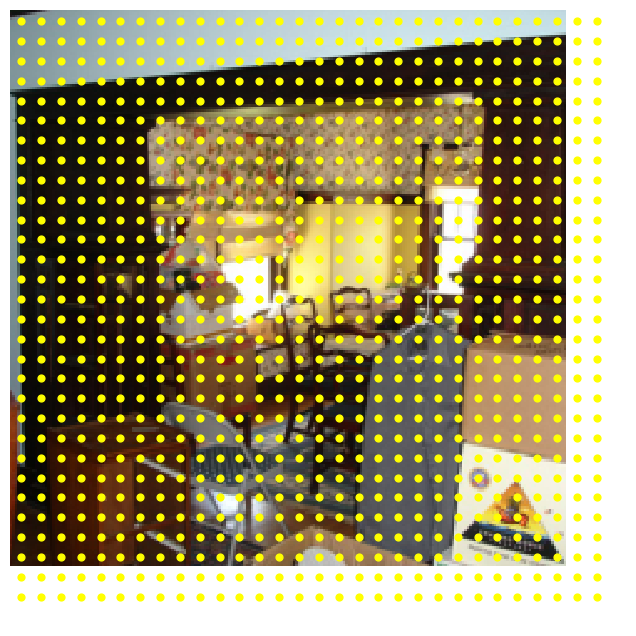

********************************************************************************
All locations of the image FPN level = p4
stride = 16


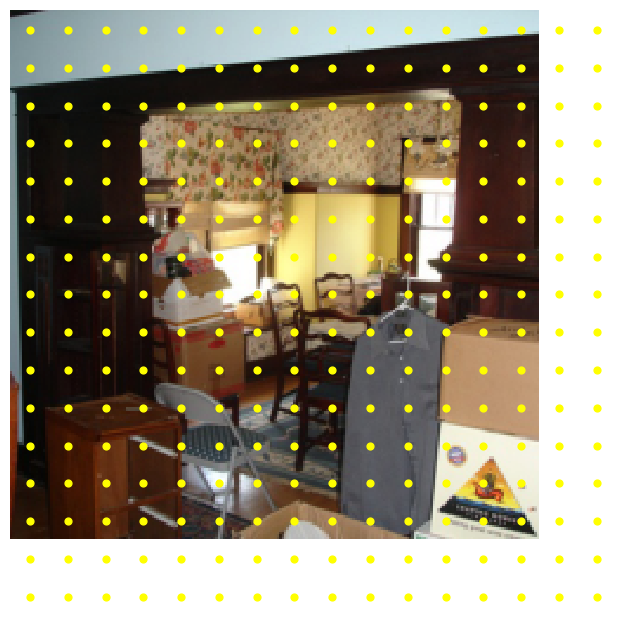

********************************************************************************
All locations of the image FPN level = p5
stride = 32


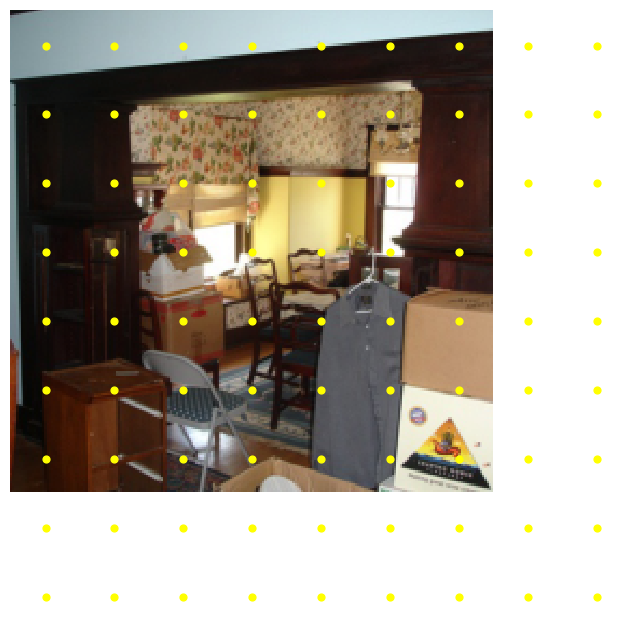

In [15]:
from common import get_fpn_location_coords

# Get shapes of each FPN level feature map. We don't call these "dummy" because
# they don't depend on the _values_ of features, but rather only shapes.
fpn_feats_shapes = {
    level_name: feat.shape for level_name, feat in dummy_fpn_feats.items()
}

# Get CPU tensors for this sanity check: (you can pass `device=` argument.
locations_per_fpn_level = get_fpn_location_coords(fpn_feats_shapes, backbone.fpn_strides)

# First five location co-ordinates for each feature maps.
expected_locations = {
    "p3": torch.tensor([[4.0, 4.0], [4.0, 12.0], [4.0, 20.0], [4.0, 28.0], [4.0, 36.0]]),
    "p4": torch.tensor([[8.0, 8.0], [8.0, 24.0], [8.0, 40.0], [8.0, 56.0], [8.0, 72.0]]),
    "p5": torch.tensor([[16.0, 16.0], [16.0, 48.0], [16.0, 80.0], [16.0, 112.0], [16.0, 144.0]]),
}

print("First five locations per FPN level (absolute image co-ordinates):")
for level_name, locations in locations_per_fpn_level.items():
    print(f"{level_name}: {locations[:5, :].tolist()}")
    print("rel error: ", rel_error(expected_locations[level_name], locations[:5, :]))

# Visualize all the locations on first image from training data.
for level_name, locations in locations_per_fpn_level.items():
    # Un-normalize image to bring in [0, 1] RGB range.
    image = inverse_norm(val_dataset[0][1])

    print("*" * 80)
    print(f"All locations of the image FPN level = {level_name}")
    print(f"stride = {backbone.fpn_strides[level_name]}")
    detection_visualizer(image, val_dataset.idx_to_class, points=locations.tolist())

**NOTE:** We will use "feature map location" and "feature center" interchangeably from now on, they mean the same thing — center of the receptive field of a particular feature map location at any FPN level **(yellow points above)**.

### Matching feature map locations with GT boxes

Now we match these locations with GT boxes for supervising our network. FCOS matches some `N` locations at any given FPN level with `M` GT boxes applying two rules:

> Location $N_i$ is matched with box $M_i$ if it lies inside the box. If any location lies inside two boxes, then it is matched with the smaller box. If a location does not lie inside any box, it is assigned "background".

> _Multi-scale matching_ for different FPN levels — for a particular FPN level, FCOS only considers a subset of boxes based on their size. Intuitively, larger boxes are assigned to `p5` and smaller boxes are assigned to `p3`.

As a result of this matching, each location wil receive a bounding box and a class label (that is 5D vector `(x1, y1, x2, y2, C)`) out of `M` GT boxes, or a background `(-1, -1, -1, -1, -1)`.

We have implemented this matching procedure for you, because we thought it is non-trivial for the limited time and difficulty level of this assignment.
However, you are required to understand its input/output format and how to use it, shown in the following cell.
We recommend you to read its implementation in `one_stage_detector.py` with name `fcos_match_locations_to_gt`. While not required for this assignment, you may refer to [Section 3.2 in FCOS paper](https://arxiv.org/abs/1904.01355).

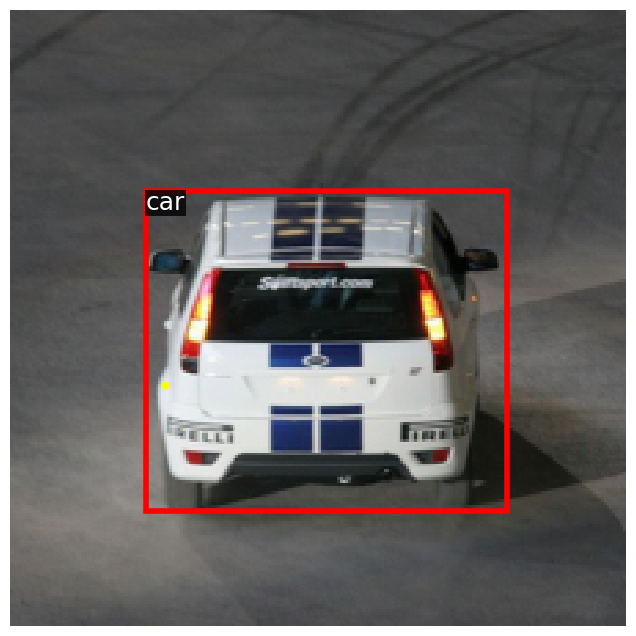

In [16]:
import random
from one_stage_detector import fcos_match_locations_to_gt

# Get an image and its GT boxes from train dataset.
_, image, gt_boxes = train_dataset[0]

# Dictionary with keys {"p3", "p4", "p5"} and values as `(N, 5)` tensors
# giving matched GT boxes.
matched_boxes_per_fpn_level = fcos_match_locations_to_gt(
    locations_per_fpn_level, backbone.fpn_strides, gt_boxes
)

# Visualize one selected location (yellow point) and its matched GT box (red).
# Get indices of matched locations (whose class ID is not -1) from P3 level.
FPN_LEVEL = "p4"
fg_idxs_p3 = (matched_boxes_per_fpn_level[FPN_LEVEL][:, 4] != -1).nonzero()

# NOTE: Run this cell multiple times to see different matched points. For car
# image, p3/5 will not work because the one and only box was already assigned
# to p4 due to its compatible size to p4 stride.
_idx = random.choice(fg_idxs_p3)

detection_visualizer(
    inverse_norm(image),
    val_dataset.idx_to_class,
    bbox=matched_boxes_per_fpn_level[FPN_LEVEL][_idx],
    points=locations_per_fpn_level[FPN_LEVEL][_idx]
)

In the above illustration, we can see one random location on `p3` level (**yellow**), and its matched GT box (**red**).
With these GT targets assigned, the FCOS preiction heads are task to predict this class label (**person**) at the given location, regress the distances between this location to all box edges `(left, top, right, bottom)`, and regress a real-valued centerness at this location. 

From now on, it would help to think about FCOS behavior for a _single_ location, assuming that it has a matched GT box (or background). We shall now discuss and implement the output format of prediction layers and loss functions during training.

## GT Targets for box regression

The box regression head is tasked with predicting FOUR values: distances from feature locations (**yellow points**) to box edges (**red box**) as we discussed above `(left, top, right, bottom)` or simply as we could call it — `LTRB`.
Recall that all locations and GT boxes so far are represented in absolute image co-ordinates — they range from `(0, 224)` for our input image, and can be even larger for abritrarily large input images.

We cannot use this absolute co-ordinate format with our network because regressing to such large real-valued numbers will cause the gradients to explode.
Hence, FCOS normalizes `LTRB` targets by the `stride` of FPN levels. Hence in the above example, consider FPN level P3 (`stride = 8`), the location to be `(xc, yc)` (**yellow point**) and matched GT box have co-ordinates `(x1, y1, x2, y2)`. Then the `LTRB` regression targets used to supervise the network are:

    l = (xc - x1) / stride              t = (yc - y1) / stride
    r = (x2 - xc) / stride              b = (y2 - yc) / stride

These are commonly referred as "deltas" of box regression. Since the model is supervised to predict these during training time, one must apply an inverse transformation to these during inference to convert network outputs to predicted boxes in absolute image co-ordinates.

Next, you will implement this transformation logic and its inverse in two separate functions:

1. `fcos_get_deltas_from_locations`: Accepts locations (centers) and GT boxes, and returns deltas. Required for training supervision.
2. `fcos_apply_deltas_to_locations`: Accepts predicted deltas and locations, and returns predicted boxes. Required during inference.

Run the following cell to check your implementation.

In [28]:
import torch

from one_stage_detector import fcos_get_deltas_from_locations, fcos_apply_deltas_to_locations

# Three hard-coded input boxes and three points lying inside them.
# Add a dummy class ID = 1 indicating foreground
input_boxes = torch.Tensor(
    [[10, 15, 100, 115, 1], [30, 20, 40, 30, 1], [120, 100, 200, 200, 1]]
)
input_locations = torch.Tensor([[30, 40], [32, 29], [125, 150]])

# Here we do a simple sanity check - getting deltas for a particular set of boxes
# and applying them back to centers should give us the same boxes. Setting a random
# stride = 8, it should not affect reconstruction if it is same on both sides.
_deltas = fcos_get_deltas_from_locations(input_locations, input_boxes, stride=8)
output_boxes = fcos_apply_deltas_to_locations(_deltas, input_locations, stride=8)

print("Rel error in reconstructed boxes:", rel_error(input_boxes[:, :4], output_boxes))

# Another check: deltas for GT class label = -1 should be -1.
background_box = torch.Tensor([[-1, -1, -1, -1, -1]])
input_location = torch.Tensor([[100, 200]])

_deltas = fcos_get_deltas_from_locations(input_location, background_box, stride=8)
output_box = fcos_apply_deltas_to_locations(_deltas, input_location, stride=8)

print("Background deltas should be all -1    :", _deltas)

# Output box should be the location itself ([100, 200, 100, 200])
print("Output box with background deltas     :", output_box)

Rel error in reconstructed boxes: 0.0
Background deltas should be all -1    : tensor([[-1., -1., -1., -1.]])
Output box with background deltas     : tensor([[100., 200., 100., 200.]])


## GT targets for centerness regression

Given the GT deltas for a location `(left, top, right, bottom)` as computed above, FCOS defines centerness as:

$$centerness = \sqrt{\frac{\min(left, right) \cdot \min(top, bottom)}{\max(left, right) \cdot \max(top, bottom)}}$$

This value is maximum (1) when `left = right` and `top = bottom`, implying the center of GT box.
At the edge of a box, one of these values will be zero, which gives zero centerness at edges.
Centerness regression head uses these values as targets — you need to implement them next in `fcos_make_centerness_targets`.
Execute the next cell to verify your impkementation, your relative error should be less than 1e-7

In [32]:
import torch

from one_stage_detector import fcos_make_centerness_targets

# Three hard-coded input boxes and three points lying inside them.
# Add a dummy class ID = 1 indicating foreground
input_boxes = torch.Tensor(
    [
        [10, 15, 100, 115, 1],
        [30, 20, 40, 30, 1],
        [-1, -1, -1, -1, -1]  # background
    ]
)
input_locations = torch.Tensor([[30, 40], [32, 29], [125, 150]])

expected_centerness = torch.Tensor([0.30860671401, 0.1666666716, -1.0])

_deltas = fcos_get_deltas_from_locations(input_locations, input_boxes, stride=8)
centerness = fcos_make_centerness_targets(_deltas)
print("Rel error in centerness:", rel_error(centerness, expected_centerness))

torch.Size([3])
Rel error in centerness: 0.0


## Loss Functions

At this point, every model prediction is assigned a GT target during training.
We will proceed to compute losses for training the model.

FCOS has three prediction layers, that use the following use functions:

1. **Object classification:** FCOS uses [Focal Loss](https://arxiv.org/abs/1708.02002), an extension of cross-entropy loss that deals with class-imbalance. FCOS faces a class imbalance issue because a majority of locations would be assigned "background". If not handled properly, the model will simply learn to predict "background" for every location.

2. **Box regression:** We will use a simple L1 loss to minimize the difference between predicted and GT `LTRB` deltas. FCOS uses [Generalized Intersection-over-Union](https://giou.stanford.edu/) loss, which empirically gives slightly better results but is slightly slower — we use L1 loss due to Colab time limits. (You are not required to understand GIoU for this assignment)

3. **Centerness regression:** Centerness predictions and GT targets are real-valued numbers in `[0, 1]`, so FCOS uses binary cross-entropy (BCE) loss to optimize it. One may use an L1 loss, but BCE empirically works slightly better.

**Total loss:** We get three loss components _per location_. Out of these, (2) and (3) are set to zero for _background locations_ because their GT boxes (and hence centerness) are not defined. Total loss is the sum of all losses per location, averaged by the number of _foreground locations_ (that matched with any GT box). The number of foreground locations are highly variable per image, depending on density of objects in it. Hence for training stability, the loss is instead average by an _exponential moving average of foreground locations_ (think like the running mean/var of BN, in past assignment).

You have implemented some basic forms of these losses in past assignment.
So now you are allowed to directly use builtin functions from PyTorch and Torchvision.
We highly encourage you to check out their implementation and understand them closely.

The following two cells demonstrate their use with dummy inputs and targets.
Execute them and read them carefully so you understand how to call these functions — immediately after, you will use them with actual predictions of FCOS, and assigned GT targets (that you implemented so far).

In [33]:
import torch
from torchvision.ops import sigmoid_focal_loss


# Sanity check: dummy model predictions for TWO locations, and
# NUM_CLASSES = 5 (typically there are thousands of locations
# across all FPN levels).
# shape: (batch_size, num_locations, num_classes)
dummy_pred_cls_logits = torch.randn(1, 2, 5)

# Corresponding one-hot vectors of GT class labels (2, -1), one
# foreground and one background.
# shape: (batch_size, num_locations, num_classes)
dummy_gt_classes = torch.Tensor([[[0, 0, 1, 0, 0], [0, 0, 0, 0, 0]]])

# This loss expects logits, not probabilities (DO NOT apply sigmoid!)
cls_loss = sigmoid_focal_loss(
    inputs=dummy_pred_cls_logits, targets=dummy_gt_classes
)
print("Classification loss (dummy inputs/targets):")
print(cls_loss)

print(f"Total classification loss (un-normalized): {cls_loss.sum()}")

Classification loss (dummy inputs/targets):
tensor([[[6.3976e-01, 1.4746e-01, 1.0794e-04, 4.0542e-03, 1.1287e-02],
         [1.8720e-03, 3.0860e-01, 6.6703e-03, 2.8679e-01, 5.2909e-01]]])
Total classification loss (un-normalized): 1.9356931447982788


In [34]:
from torch.nn import functional as F
from one_stage_detector import fcos_get_deltas_from_locations


# Sanity check: dummy model predictions for TWO locations, and
# NUM_CLASSES = 2 (typically there are thousands of locations
# across all FPN levels).
# Think of these as first two locations locations of "p5" level.
dummy_locations = torch.Tensor([[32, 32], [64, 32]])
dummy_gt_boxes = torch.Tensor(
    [
        [1, 2, 40, 50, 2],
        [-1, -1, -1, -1, -1]  # Same GT classes as above cell.
    ]
)
# Centerness is just a dummy value:
dummy_gt_centerness = torch.Tensor([0.6, -1])

# shape: (batch_size, num_locations, 4 or 1)
dummy_pred_boxreg_deltas = torch.randn(1, 2, 4)
dummy_pred_ctr_logits = torch.randn(1, 2, 1)

# Collapse batch dimension.
dummy_pred_boxreg_deltas = dummy_pred_boxreg_deltas.view(-1, 4)
dummy_pred_ctr_logits = dummy_pred_ctr_logits.view(-1)

# First calculate box reg loss, comparing predicted boxes and GT boxes.
dummy_gt_deltas = fcos_get_deltas_from_locations(
    dummy_locations, dummy_gt_boxes, stride=32
)
# Multiply with 0.25 to average across four LTRB components.
loss_box = 0.25 * F.l1_loss(
    dummy_pred_boxreg_deltas, dummy_gt_deltas, reduction="none"
)

# No loss for background:
loss_box[dummy_gt_deltas < 0] *= 0.0
print("Box regression loss (L1):", loss_box)


# Now calculate centerness loss.
centerness_loss = F.binary_cross_entropy_with_logits(
    dummy_pred_ctr_logits, dummy_gt_centerness, reduction="none"
)
# No loss for background:
centerness_loss[dummy_gt_centerness < 0] *= 0.0
print("Centerness loss (BCE):", centerness_loss)

# In the expected loss, the first value will be different everytime due to random dummy
# predictions. But the second value should always be zero - corresponding to background.

Box regression loss (L1): tensor([[0.1653, 0.0653, 0.0440, 0.2718],
        [0.0000, 0.0000, 0.0000, 0.0000]])
Centerness loss (BCE): tensor([0.6772, 0.0000])


## Object detection module

We will now combine everything into the `FCOS` class in `one_stage_detector.py`.
Implement the `__init__` and `forward` functions of this module — you have already done most of the heavy lifting, you simply need to call the functions in a correct way!
Use the previous two cells as a reference to implement loss calculation in `forward()`.

## Overfit small data

To make sure that everything is working as expected, we can try to overfit the detector to a small subset of data.
The training loss may increase at first (due to EMA loss averaging) but then should generally go down.
We also implemented the `train_detector` function which runs the training loop for a detector.
You can read its implementation in `a4_helper.py`. 

In [ ]:
from a4_helper import train_detector
from one_stage_detector import FCOS

reset_seed(0)

# Take equally spaced examples from training dataset to make a subset.
small_dataset = torch.utils.data.Subset(
    train_dataset,
    torch.linspace(0, len(train_dataset) - 1, steps=BATCH_SIZE * 10).long()
)
small_train_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS
)

detector = FCOS(
    num_classes=NUM_CLASSES,
    fpn_channels=64,
    stem_channels=[64, 64],
)
detector = detector.to(DEVICE)

train_detector(
    detector,
    small_train_loader,
    learning_rate=5e-3,
    max_iters=500,
    log_period=20,
    device=DEVICE,
)

## Train a net

Now that we are confident that the training code is working properly, let's train the network on more data and for longer. We will train for 9000 iterations; this should take about 30 minutes on a K80 GPU. For initial debugging, you may want to train for lesser durations (say 1000 iterations).

Note that real object detection systems typically train for 12-24 hours, distribute training over multiple GPUs, and use much faster GPUs. As such our result will be far from the state of the art, but it should give some reasonable results!

In [ ]:
reset_seed(0)

# Slightly larger detector than in above cell.
detector = FCOS(
    num_classes=NUM_CLASSES,
    fpn_channels=128,
    stem_channels=[128, 128],
)
detector = detector.to(DEVICE)

train_detector(
    detector,
    train_loader,
    learning_rate=8e-3,
    max_iters=9000,
    log_period=100,
    device=DEVICE,
)

# After you've trained your model, save the weights for submission.
weights_path = os.path.join(GOOGLE_DRIVE_PATH, "fcos_detector.pt")
torch.save(detector.state_dict(), weights_path)

## Non-Maximum Suppression (NMS)

The definition of NMS and instructions on how to compute NMS can be found in the lecture slides (79-83):
https://web.eecs.umich.edu/~justincj/slides/eecs498/WI2022/598_WI2022_lecture13.pdf

Implement the `nms` function in `common.py`. We then compare your implementation of NMS with the implementation in torchvision. Most likely, your implementation will be faster on CPU than on CUDA, and the torchvision implementation will likely be much faster than yours.
This is expected, but your implementation should produce the same outputs as the torchvision version.

In [ ]:
# Perform imports here to make this cell runnble independently,
# students are likely to spend good mount of time here and it is
# best to not require execution of prior cells.
import time
import torch
import torchvision

from common import nms
from eecs598 import reset_seed

reset_seed(0)


boxes = (100.0 * torch.rand(5000, 4)).round()
boxes[:, 2] = boxes[:, 2] + boxes[:, 0] + 1.0
boxes[:, 3] = boxes[:, 3] + boxes[:, 1] + 1.0
scores = torch.randn(5000)

names = ["your_cpu", "torchvision_cpu", "torchvision_cuda"]
iou_thresholds = [0.3, 0.5, 0.7]
elapsed = dict(zip(names, [0.0] * len(names)))
intersects = dict(zip(names[1:], [0.0] * (len(names) - 1)))

for iou_threshold in iou_thresholds:
    tic = time.time()
    my_keep = nms(boxes, scores, iou_threshold)
    elapsed["your_cpu"] += time.time() - tic

    tic = time.time()
    tv_keep = torchvision.ops.nms(boxes, scores, iou_threshold)
    elapsed["torchvision_cpu"] += time.time() - tic
    intersect = len(set(tv_keep.tolist()).intersection(my_keep.tolist())) / len(tv_keep)
    intersects["torchvision_cpu"] += intersect

    tic = time.time()
    tv_cuda_keep = torchvision.ops.nms(boxes.to(device=DEVICE), scores.to(device=DEVICE), iou_threshold).to(
        my_keep.device
    )
    torch.cuda.synchronize()
    elapsed["torchvision_cuda"] += time.time() - tic
    intersect = len(set(tv_cuda_keep.tolist()).intersection(my_keep.tolist())) / len(
        tv_cuda_keep
    )
    intersects["torchvision_cuda"] += intersect

for key in intersects:
    intersects[key] /= len(iou_thresholds)

# You should see < 1% difference
print("Testing NMS:")
print("Your        CPU  implementation: %fs" % elapsed["your_cpu"])
print("torchvision CPU  implementation: %fs" % elapsed["torchvision_cpu"])
print("torchvision CUDA implementation: %fs" % elapsed["torchvision_cuda"])
print("Speedup CPU : %fx" % (elapsed["your_cpu"] / elapsed["torchvision_cpu"]))
print("Speedup CUDA: %fx" % (elapsed["your_cpu"] / elapsed["torchvision_cuda"]))
print(
    "Difference CPU : ", 1.0 - intersects["torchvision_cpu"]
)  # in the order of 1e-3 or less
print(
    "Difference CUDA: ", 1.0 - intersects["torchvision_cuda"]
)  # in the order of 1e-3 or less

## Inference

Now, follow the instructions in `FCOS.inference` to implement the core components for inference.

Visualize the output from the trained model on a few eval images by running the code below, the bounding boxes should be somewhat accurate. They would get even better by using a bigger model and training it for longer.

In [ ]:
from a4_helper import inference_with_detector
from one_stage_detector import FCOS


weights_path = os.path.join(GOOGLE_DRIVE_PATH, "fcos_detector.pt")

# Re-initialize so this cell is independent from prior cells.
detector = FCOS(
    num_classes=NUM_CLASSES, fpn_channels=128, stem_channels=[128, 128]
)
detector.to(device=DEVICE)
detector.load_state_dict(torch.load(weights_path, map_location="cpu"))

# Prepare a small val daataset for inference:
small_dataset = torch.utils.data.Subset(
    val_dataset,
    torch.linspace(0, len(val_dataset) - 1, steps=10).long()
)
small_val_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=1, pin_memory=True, num_workers=NUM_WORKERS
)

inference_with_detector(
    detector,
    small_val_loader,
    val_dataset.idx_to_class,
    score_thresh=0.5,
    nms_thresh=0.5,
    device=DEVICE,
    dtype=torch.float32,
)

## Evaluation
Compute mean Average Precision (mAP). Introduction on mAP see lecture slides (p46-57): https://web.eecs.umich.edu/~justincj/slides/eecs498/FA2020/598_FA2020_lecture15.pdf


Run the following to evaluate your detector on the PASCAL VOC validation set. Evaluation should take a few minutes, and with default hyperparameters declared above, you should see at least 22% mAP.

The state of the art on this dataset is >80% mAP! To achieve these results we would need to use a much bigger network, and train with more data and for much longer, but that is beyond the scope of this assigment. **Optional:** For better mAP, you may use more conv layers in head stem, train for 25K+ iterations, and use ResNet-50/RegNet-4GF models in backbone.
But make sure you revert the code back for grading purposes.

In [ ]:
inference_with_detector(
    detector,
    val_loader,
    val_dataset.idx_to_class,
    score_thresh=0.4,
    nms_thresh=0.6,
    device=DEVICE,
    dtype=torch.float32,
    output_dir="mAP/input",
)
!cd mAP && python main.py

# This script outputs an image containing per-class AP. Display it here:
from IPython.display import Image
Image(filename="./mAP/output/mAP.png")